## Neuron
Create spike raster from inhomogeneous Poisson processes, where the time-dependent rate is modelled as an OU process

In [1]:
using Pkg
Pkg.activate("../")
using CairoMakie
using Random
using Distributions
using StatsBase
using LinearAlgebra
using DSP
path_figures="/Users/johannes/research/figures_perspective_heart_brain/subfigures/"
#path_figures="/Users/johannes/research/figures_perspective_heart_brain/figures/subfigures/"

  Activating project at `~/git/projects/perspective_heart_and_brain`


"/Users/johannes/research/figures_perspective_heart_brain/subfigures/"

# EEG data
From https://www.ukbonn.de/epileptologie/arbeitsgruppen/ag-lehnertz-neurophysik/downloads/ 

Reference: Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state,Phys. Rev. E, 64, 061907

Dataset C, sample N062 as suggested in the reference link for patients in seizure free intervals

Dataset E, sample S056 as suggested in the reference link for patient with seizure activity

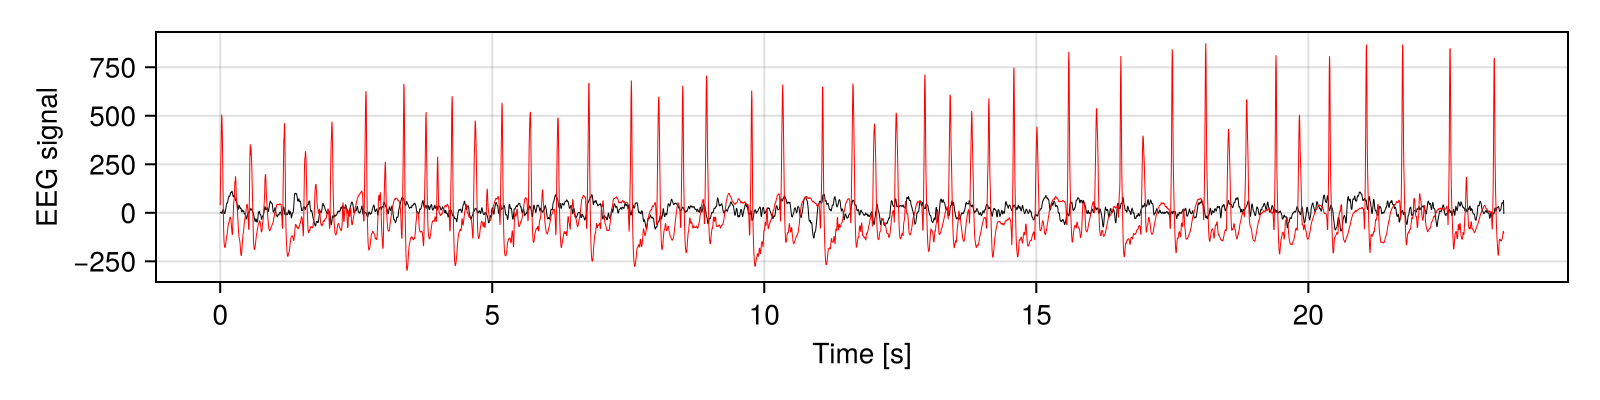

In [7]:
using DelimitedFiles
function eeg_data(path, file)
    eeg_trace = readdlm(joinpath(path, file))[:,1]
    dt = 1/173.61
    eeg_time = 0:dt:(length(eeg_trace)-1)*dt

    return eeg_time, eeg_trace
end

# load data from textfile
control_t, control_eeg = eeg_data("../data/Andrzejak_et_al_PhysRevE_2001/C", "N062.txt")
seizure_t, seizure_eeg = eeg_data("../data/Andrzejak_et_al_PhysRevE_2001/E", "S056.txt")

fig = Figure(size = (800, 200))
ax = Axis(fig[1, 1]; xlabel = "Time [s]", ylabel = "EEG signal")
lines!(control_t, control_eeg, color = :black, linewidth = 0.5)
lines!(seizure_t, seizure_eeg, color = :red, linewidth = 0.5)
fig

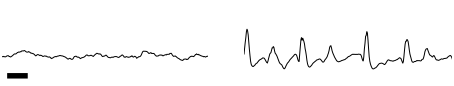

In [15]:
cm = 28.3465 # pt
fig = Figure(size=(8 * cm, 1.5 * cm), fontsize=10, figure_padding=1, backgroundcolor=:transparent)
ax = Axis(fig[1, 1]; xgridvisible=false, ygridvisible=false, backgroundcolor=:transparent)
hidedecorations!(ax)
hidespines!(ax)
lines!(control_t, control_eeg, color = :black, linewidth = 0.5)
xlims!(ax, (0, 2))
ymin = -500
ymax = 1000
dy = (ymax - ymin) / 15
ylims!(ax, (ymin, ymax)) # 1500μV ?
# include a scale for the time
dt = 0.2
ts = 0.05 .+ [0,dt]
band!(ts, ones(length(ts)) * (ymin + dy), ones(length(ts)) * (ymin + 2 * dy), color=colorant"black")

# second figure to the right
ax = Axis(fig[1, 2]; xgridvisible=false, ygridvisible=false, backgroundcolor=:transparent)
hidedecorations!(ax)
hidespines!(ax)
lines!(seizure_t, seizure_eeg, color = :black, linewidth = 0.5)
xlims!(ax, (0, 2))
ylims!(ax, (ymin, ymax)) # 1500μV ?

# save as pdf with transparent background
save(path_figures*"eeg_malfunction.pdf", fig, pt_per_unit=1)
fig

### small analysis of EEG signal to justify spiking generation

In [16]:
# calculate autocorrelation of EEG signal
function autocorrelation(x::Vector{T}, k::Int, mean = nothing) where T
    if isnothing(mean)
        mean = sum(x)/length(x)
    end

    C = 0
    for i in 1:(length(x)-k)
        C += (x[i] - mean)*(x[i+k] - mean)
    end
    return C / (length(x)-k)

end
ks = 0:500
Cs = [autocorrelation(eeg_example, k) for k in ks]
Cs = Cs / Cs[1];

[0.16578569683705643, 0.10591361449950815, 0.946182667969959, 0.013046536578593905]
first timescale: 0.10591361449950815 +/- 0.03307080283440342
second timescale: 0.013046536578593905 +/- 0.0017576564973908633


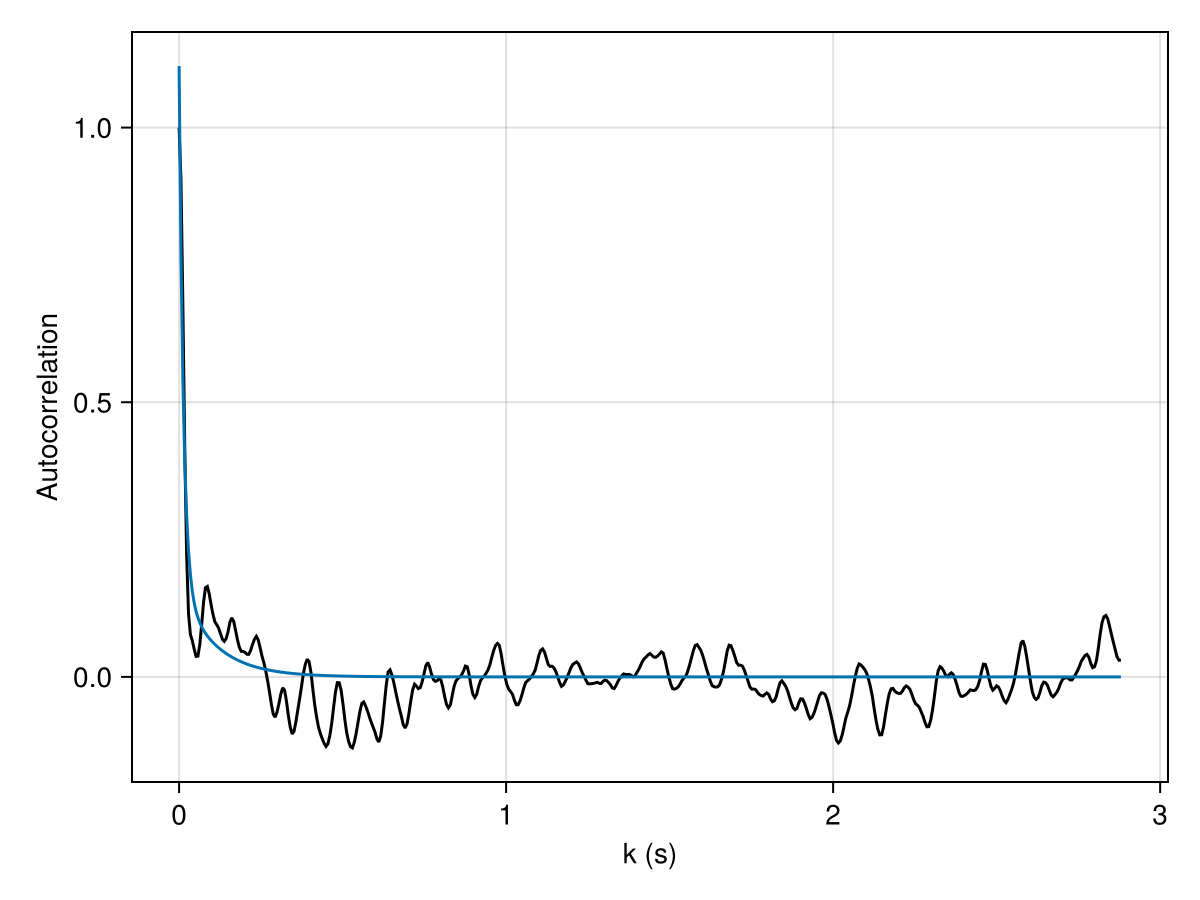

In [17]:
# determine autcorrelation time as decay time of initial autocorrelation
using LsqFit
@. model(x, p) = p[1]*exp(-x/p[2]) + p[3]*exp(-x/p[4])
dt = eeg_t[2] - eeg_t[1]

myfit = curve_fit(model, ks*dt, Cs, [1,0.5, 0.1, 2])
println(myfit.param)
param = myfit.param
error = stderror(myfit)
print("first timescale: ", param[2], " +/- ", error[2], "\n")
print("second timescale: ", param[4], " +/- ", error[4], "\n")

# plot
fig = Figure()
ax = Axis(fig[1, 1]; xlabel = "k (s)", ylabel = "Autocorrelation")
lines!(ax, ks*dt, Cs, color = :black)
lines!(ax, ks*dt, model(ks*dt, param) )
fig

In [18]:
#Average correlation function from all 100 traces from dataset
using ProgressMeter
using Printf 
ks = 0:500
Cs = zeros(length(ks))
@showprogress for i in 1:100
    eeg_t, eeg_example = eeg_data("../data/Andrzejak_et_al_PhysRevE_2001_setA", "Z"*lpad(i, 3, '0')*".txt")
    Cs_tmp = [autocorrelation(eeg_example, k) for k in ks]
    Cs += Cs_tmp ./ Cs_tmp[1]
end
Cs = Cs / 100


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


501-element Vector{Float64}:
 1.0
 0.9243492974050608
 0.7594029279120481
 0.5678716898444497
 0.41366345235474783
 0.3153260405502208
 0.26121758695062935
 0.23130856016584356
 0.20808052563065552
 0.19594720381824107
 ⋮
 0.011162062371706652
 0.014356811854736478
 0.013041043232074374
 0.011344834966130908
 0.011147305022931533
 0.00958974357600009
 0.007182693255244565
 0.00721283287490422
 0.008271987566200137

0.2995219169402684

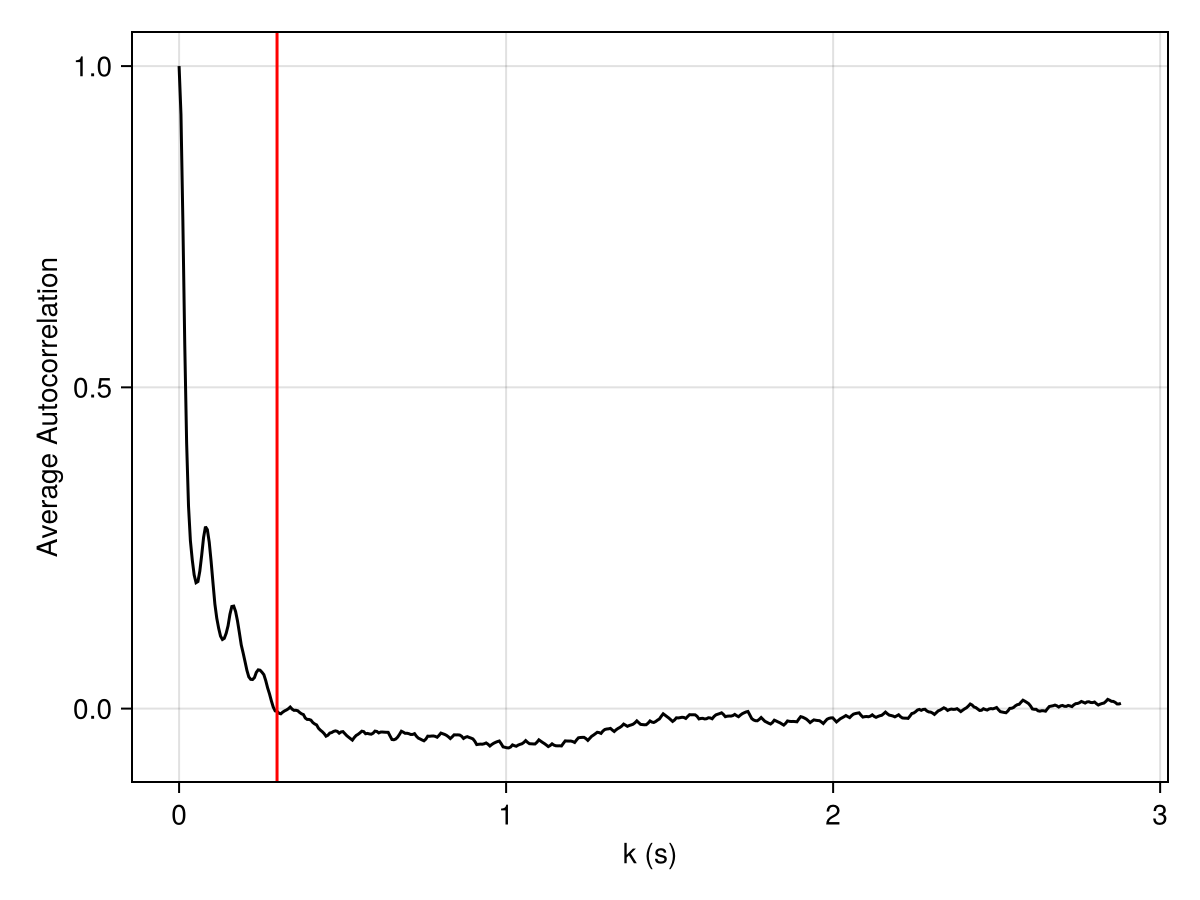

In [19]:
# plot and average autocorrelation and check for zero crossing
tau = findfirst(x -> x < 0, Cs) * dt
print(tau)

fig = Figure()
ax = Axis(fig[1, 1]; xlabel = "k (s)", ylabel = "Average Autocorrelation")
lines!(ax, ks*dt, Cs, color = :black)
# vertical line at tau
vlines!(ax, [tau], color = :red)
fig

# Spike times from inhomog. Poisson with population rate described by OU process with 0.1s autocorrelation time

0.10984895264594359


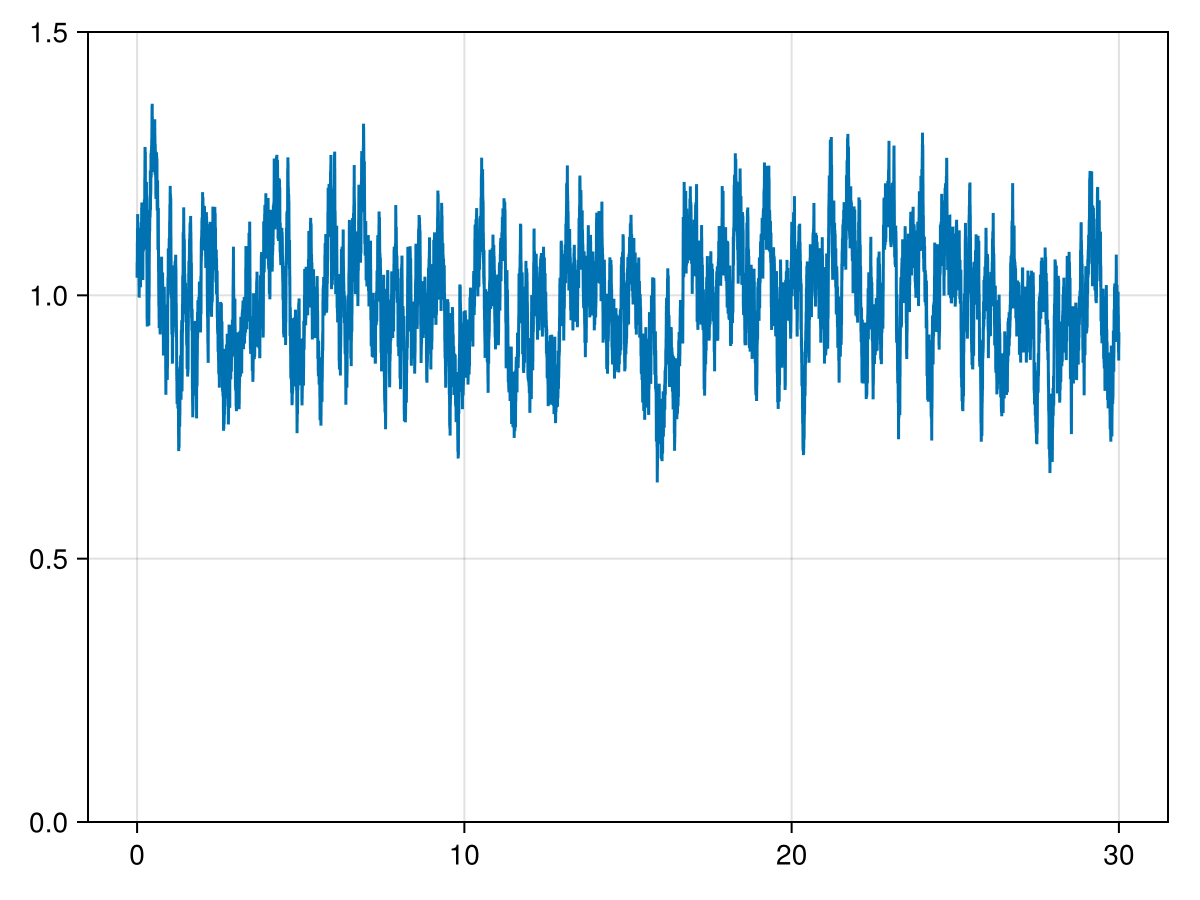

In [20]:
N = 50
# time-dependent rate of population (population AR process with correlation should be the same as OU...)
rate_μ = 1   # Hz
rate_σ = 0.1 # Hz
τ = 0.1   # s
dt = 1e-4 # s
t = 0:dt:30
# ornstein uhlenbeck process for the rate
rate = zeros(length(t))
rate[1] = rate_μ + rate_σ * randn()
for i in 2:length(rate)
    rate[i] = rate[i-1] + (rate_μ - rate[i-1]) * dt / τ + rate_σ * sqrt(2 * dt / τ) * randn()
end
# print std of rate
println(std(rate))
# quick plot to show the outcome
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax, t, rate)
# y axis range
ylims!(ax, 0, 1.5)
fig

In [21]:
# spike times as independent realizations of inhomogeneous Poisson process 
spikes = [ Float64[] for _ in 1:N]
# here, they all share the same population rate such that we can generate a single process with rate = r*N and assign each spike to a random neurons
rate_all = rate * N
rate_max = maximum(rate_all)
t_ = 0
# advance time with homogeneous poisson process at rate_max (i.e. exp. inter-event times)
dist_dt = Exponential(1/rate_max)
while t_ < t[end]
    #t_ += -log(rand()) / rate_max
    t_ += rand(dist_dt)
    # a spike happens at t_ with probability rate_all[findfirst(x -> x > t_, t)]/rate_max
    if t_ < t[end] && rand() < rate_all[findfirst(x -> x > t_, t)]/rate_max
        # choose random neuron to append this spike time
        push!(spikes[rand(1:N)], t_)
    end
end
spikes

50-element Vector{Vector{Float64}}:
 [0.42369534617407967, 1.2397464217259335, 2.5482302055653716, 2.681632247096738, 3.242548962163968, 6.874615909341259, 7.274452742562137, 8.985880438300006, 9.857144547392629, 10.053257439372222  …  22.918749490040774, 24.958817484092037, 25.081340222188945, 25.46297863667456, 26.340827854965376, 27.854409751290344, 28.31825656288478, 29.137209371864216, 29.383792671029834, 29.524731240460646]
 [1.0346761864282863, 1.5754382589001155, 1.7611553526489192, 2.1825017371474065, 2.942037381914881, 3.441063755863875, 3.6083815419218648, 3.6142590305342024, 4.270923613975812, 5.855551269524529  …  24.769600405362155, 25.629294520953078, 26.224252676876397, 26.993216428697867, 27.119450720719026, 27.182574216429334, 28.46218587247516, 29.338972008716116, 29.856938771859642, 29.94610451492343]
 [1.961653249026984, 2.357151499706628, 2.8936065512229283, 3.388347455751272, 4.236214166248665, 6.837641651586917, 6.972140913411572, 7.77998435927358, 7.97587670902

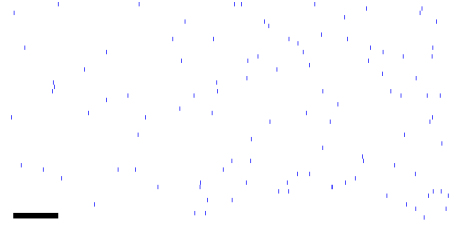

In [22]:
# spike rater plot
cm = 28.3465 # pt
fig = Figure(size = (8*cm, 4*cm), fontsize=10, figure_padding = 1, backgroundcolor = :transparent)
ax = Axis(fig[1,1]; xgridvisible = false, ygridvisible = false, backgroundcolor = :transparent)
hidedecorations!(ax)
hidespines!(ax)
# set xlims
xlims!(ax, 0, 2.0)
ymin=-0.5
ymax=N + 0.5
dy=(ymax-ymin)/40
ylims!(ax, ymin, ymax)
# the spikes
t_0 = 5
t_end = 7
ap_dur = 0.003 # s (duration of action potential about 1-3ms)
for index in 1:N
    for t_ in spikes[index]
        if t_0  < t_ < t_end
            ts = [t_, t_ + ap_dur]
            band!(ts.-t_0, ones(length(ts))*(index-0.50), ones(length(ts))*(index+0.50), color = :blue)
        end
    end
end
dt = 0.2
ts = 0.05 .+ [0,dt]
band!(ts, ones(length(ts)) * (ymin + dy), ones(length(ts)) * (ymin + 2 * dy), color=colorant"black")
# save as pdf
save(path_figures*"spike_rate_neuron_model.pdf", fig, pt_per_unit = 1)
fig

### Calculate Predictability
The rough idea is that heart activity pattern is highly predictable, whereas neurons are not. This is reflected in the deterministic propagation vs. memoryless Poisson model. To quantify this, we calculate the mutual information of the population activity (number active cells) with its past state. This is a 1-step active information storage that should be high in the case of deterministic patterns and zero for Poisson processes.

In [23]:
# calculate the spike count over time
bin = 0.01 # s
bins = 0:bin:t[end]
# last bin is always empty because no spike can happen after t[end]
n_t = zeros(Int, length(bins)-1)
# sort spikes into bins
for i in 1:length(spikes)
    for t_ in spikes[i]
        bin_idx = findfirst(x -> x > t_, bins) - 1
        n_t[bin_idx] += 1
    end
end

# calculate the active information storage (AIS)
println("calculate P(n_t) and P(n_t, n_t-1)")
n = collect(0:1:maximum(n_t))
p_n_t = zeros(Float64, length(n))
p_n_t_n_t_1 = zeros(Float64, length(n), length(n))
weight = 1/length(n_t)
for i in 1:length(n_t)
    idx = n_t[i]+1
    p_n_t[idx] += weight
    if i > 1
        idx_1 = n_t[i-1]+1
        p_n_t_n_t_1[idx, idx_1] += weight
    end
end

println("calculate active information storage")
ais = 0.0
for i in 1:length(n)
    for j in 1:length(n)
        if p_n_t[i] > 0 && p_n_t[j] > 0 && p_n_t_n_t_1[i, j] > 0
            ais += p_n_t_n_t_1[i, j] * log(p_n_t_n_t_1[i, j] / (p_n_t[i] * p_n_t[j]))
        end
    end
end
print("AIS: ", ais)

calculate P(n_t) and P(n_t, n_t-1)
calculate active information storage
AIS: 0.0034996055827761254